In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
import doctest
import copy

In [2]:
#https://stackoverflow.com/questions/40137950/possible-to-run-python-doctest-on-a-jupyter-cell-function
def test(func):
    '''
    Use test as a decorator to a function with doctests in Jupyter notebook. 
    Run the cell to see the results of the doctests.
    '''
    globs = copy.copy(globals())
    globs.update({func.__name__:func})
    doctest.run_docstring_examples(func, globs, verbose=True, name=func.__name__)
    return func

### Simulate straight line and circular movements with Bicycle model

Robot is at the origin (0, 0) and facing North, i.e, $\theta = \pi/2$. Assume the wheelbase of the vehicle $L$ = 0.9 m

In [3]:
@test 
def bicycle_model(curr_pose, v, delta, dt=1.0, l = 0.9):
    '''
    >>> bicycle_model((0.0,0.0,0.0), 1.0, 0.0)
    (1.0, 0.0, 0.0)
    >>> bicycle_model((0.0,0.0,0.0), 0.0, np.pi/4)
    (0.0, 0.0, 0.0)
    >>> bicycle_model((0.0, 0.0, 0.0), 1.0, np.pi/4)
    (1.0, 0.0, 1.111111111111111)
    '''
    # write code to calculate next_pose
    # refer to the kinematic equations of a bicycle model
    x, y, theta = curr_pose
    x += v*np.cos(theta)*dt
    y += v*np.sin(theta)*dt
    theta += v*np.tan(delta)*dt/l
    
    # Keep theta bounded between [-pi, pi]
    theta = np.arctan2(np.sin(theta), np.cos(theta))
    # return calculated (x, y, theta)
    return x, y, theta

Finding tests in bicycle_model
Trying:
    bicycle_model((0.0,0.0,0.0), 1.0, 0.0)
Expecting:
    (1.0, 0.0, 0.0)
ok
Trying:
    bicycle_model((0.0,0.0,0.0), 0.0, np.pi/4)
Expecting:
    (0.0, 0.0, 0.0)
ok
Trying:
    bicycle_model((0.0, 0.0, 0.0), 1.0, np.pi/4)
Expecting:
    (1.0, 0.0, 1.111111111111111)
ok


In [4]:
#straight line
straight_trajectory = []
pose = (0, 0, np.pi/2)
steps = 10
#fill in v and delta values
all_v = np.ones(steps)
all_w = np.zeros(steps)
for v, w in zip(all_v, all_w):
    # store pose
    straight_trajectory.append(pose)
    #instruction to take v, w and compute new pose
    pose = bicycle_model(pose, v, w)
straight_trajectory = np.array(straight_trajectory)
    

In [5]:
#circle
circular_trajectory = []
pose = (0, 0, np.pi/2)
steps = 10
#fill in v and delta values
all_v = np.ones(steps*100)
all_w = np.ones(steps*100)
for v, w in zip(all_v, all_w):
    # store pose
    circular_trajectory.append(pose)
    #instruction to take v, w and compute new pose
    pose = bicycle_model(pose, v, w, dt=0.01)
circular_trajectory = np.array(circular_trajectory)
   


<IPython.core.display.Javascript object>


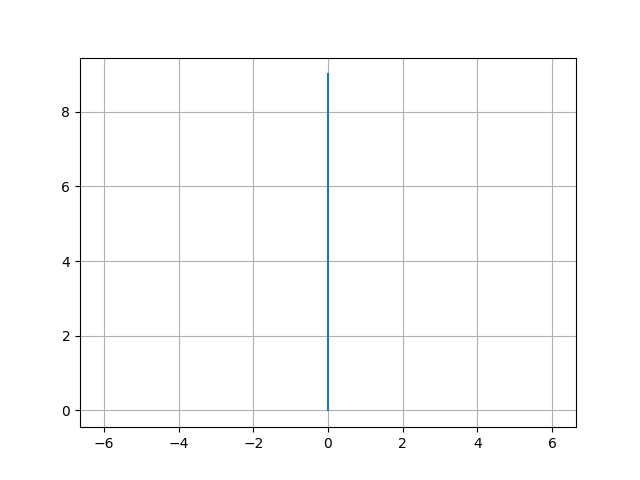

<IPython.core.display.Javascript object>


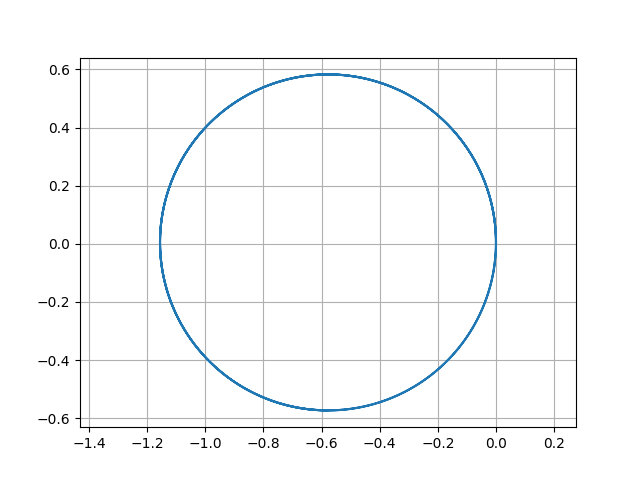

In [6]:
### Plot straight and circular trajectories
plt.figure()
plt.axes().set_aspect("equal","datalim")
plt.grid()
plt.plot(straight_trajectory[:,0], straight_trajectory[:,1])
plt.show()

plt.figure()
plt.axes().set_aspect("equal","datalim")
plt.grid()
plt.plot(circular_trajectory[:,0], circular_trajectory[:,1])
plt.show()


### Simulate Bicycle model with Open Loop control

We want the robot to follow these instructions

**straight 10m, right turn, straight 5m, left turn, straight 8m, right turn**

It is in open loop; control commands have to be calculated upfront. How do we do it?

To keep things simple in the first iteration, we can fix $v = v_c$ and change only $\delta$. To make it even simpler, $\delta$ can take only 2 values 
+ 0 when the vehicle is going straight 
+ $\delta = \delta_c$ when turning

This leaves only 2 questions to be answered
* What should be $v_c$ and $\delta_c$?
* When should $\delta$ change from 0 and back?

In [7]:
v_c = 1 # m/s
delta_c = np.pi/12 # rad/s
l = 0.9

#calculate time taken to finish a quarter turn (pi/4)
# unlike you would need to take into account v_c and L of the vehicle as well
t_turn = np.round(np.pi/2/(v_c/l*np.tan(delta_c))).astype('int')

#calculate the time taken to finish straight segments
# omega array is to be padded with equivalent zeros

t_straight1, t_straight2, t_straight3 = int(10/v_c), int(5/v_c), int(8/ v_c)

all_delta = [0]*t_straight1 + [-delta_c]*t_turn + \
        [0]*t_straight2 + [delta_c]*t_turn + \
        [0]*t_straight3 + [-delta_c]*t_turn
all_v = v_c*np.ones_like(all_delta)

<IPython.core.display.Javascript object>


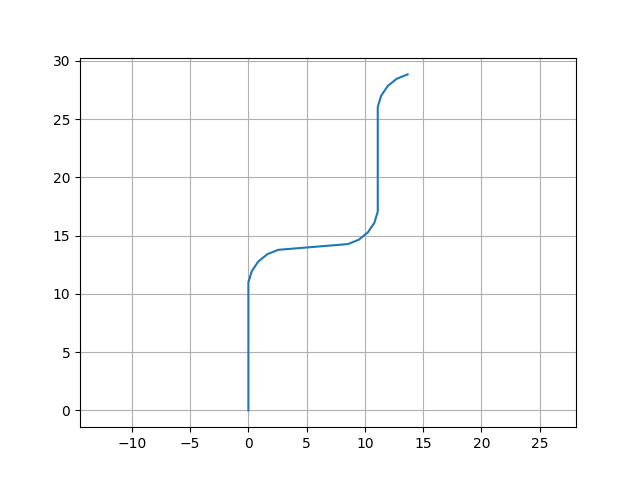

In [8]:
robot_trajectory = []
pose = np.array([0, 0, np.pi/2])
for v, delta in zip(all_v, all_delta):
    # store new pose
    robot_trajectory.append(pose)
    #instruction to take v, w and compute new pose
    pose = bicycle_model(pose, v, delta, dt=1)
robot_trajectory.append(pose)
robot_trajectory = np.array(robot_trajectory)

plt.figure()
plt.grid()
plt.axis("equal")
plt.plot(robot_trajectory[:,0],robot_trajectory[:,1])
plt.show()

Let us make a cool function out of this!

Take in as input a generic route and convert it into open-loop commands

Input format: [("straight", 5), ("right", 90), ("straight", 6), ("left", 85)]

Output: all_v, all_delta

In [9]:
def get_open_loop_commands(route, vc_slow=0.5, vc_fast=1, deltac=np.pi/12, dt=1.0, l=0.9):
    all_delta = []
    all_v = []
    deltas = {'straight': 0, 'left': deltac, 'right': -deltac}
    for manoeuvre, command in route:
        u = (command/vc_fast/dt)
        dtheta = vc_slow/l*np.tan(deltac)*dt
        v = (np.deg2rad(command)/dtheta)
        t_cmd = u if manoeuvre == 'straight' else v
        t_cmd = np.ceil(t_cmd).astype('int')
        all_delta += [deltas[manoeuvre]]*t_cmd
        if manoeuvre == "straight":
            all_v += [vc_fast]*t_cmd
        else:
            all_v += [vc_slow]*t_cmd
    return all_v, all_delta

### Unit test your function with the following inputs

+ [("straight", 5), ("right", 90), ("straight", 6), ("left", 85)]
+ $v_c = 1$
+ $delta_c = \pi/12$

In [10]:
#get_open_loop_commands()
route = [("straight", 5), ("right", 90), ("straight", 6), ("left", 85)]
all_v, all_delta = get_open_loop_commands(route,vc_slow=0.05, vc_fast=1,dt=0.1)

In [11]:
robot_trajectory = []
pose = np.array([0, 0, np.pi/2])
for v, delta in zip(all_v, all_delta):
    # store new pose
    robot_trajectory.append(pose)
    #instruction to take v, w and compute new pose
    pose = bicycle_model(pose, v, delta, dt=0.1)
robot_trajectory.append(pose)
robot_trajectory = np.array(robot_trajectory)  

<IPython.core.display.Javascript object>


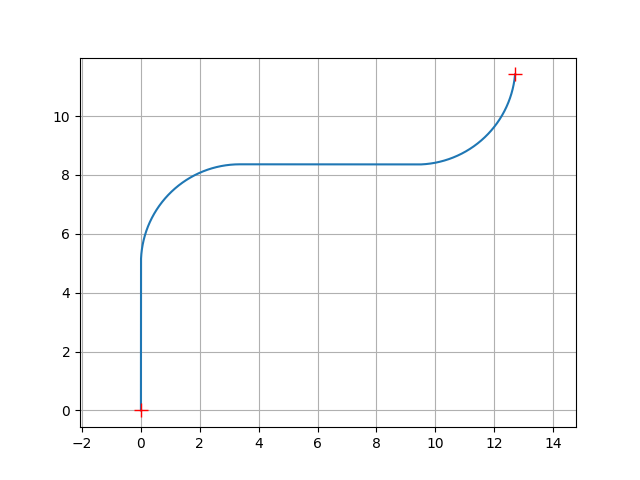

In [12]:
# plot robot trajectory
plt.figure()
plt.grid()
# plt.axes().set_aspect("equal","datalim")
plt.axis("equal")
plt.plot(robot_trajectory[:,0], robot_trajectory[:,1])

#show first and last robot positions with + markers
xi, yi, _ = robot_trajectory[0]
xf, yf, _ = robot_trajectory[-1]
plt.plot(xi, yi, 'r+', ms=10)
plt.plot(xf, yf, 'r+', ms=10)



### Shape the turn
Let us try something cooler than before (though a bit tricky in open loop). Instead of boring circular arcs, change the steering angle so that the robot orientation changes as shown in the equation below

$\theta = (\theta_i - \theta_f) * (1 - 3x^2 + 2x^3) + \theta_f  \thinspace \vee x \in [0,1]$

First let us plot this

In [13]:
def poly_turn(theta_i, theta_f, n=10):
    x = np.linspace(0, 1, num=n)
    return (theta_i-theta_f) * (1 - 3 * x * x + 2 * (x**3)) + theta_f

How does a right turn look? 

In [14]:
theta_dot = np.diff(poly_turn(np.pi/2, 0))

<IPython.core.display.Javascript object>


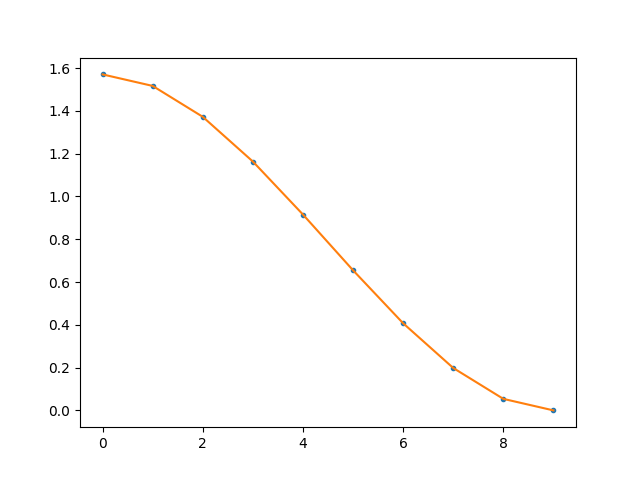

In [15]:
plt.figure()
plt.plot(poly_turn(np.pi/2, 0),'.')
plt.plot(poly_turn(np.pi/2, 0))

Now plot a left turn (North to East)

<IPython.core.display.Javascript object>


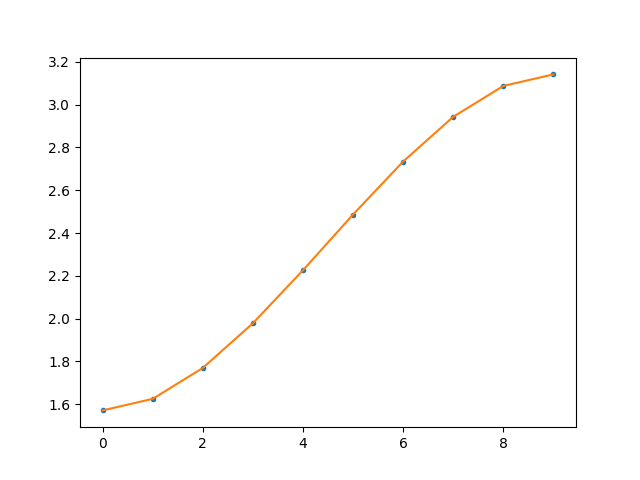

In [16]:
plt.figure()
plt.plot(poly_turn(np.pi/2,np.pi),'.')
plt.plot(poly_turn(np.pi/2,np.pi))

How does $\theta$ change when we had constant $\delta$? Plot it

<IPython.core.display.Javascript object>


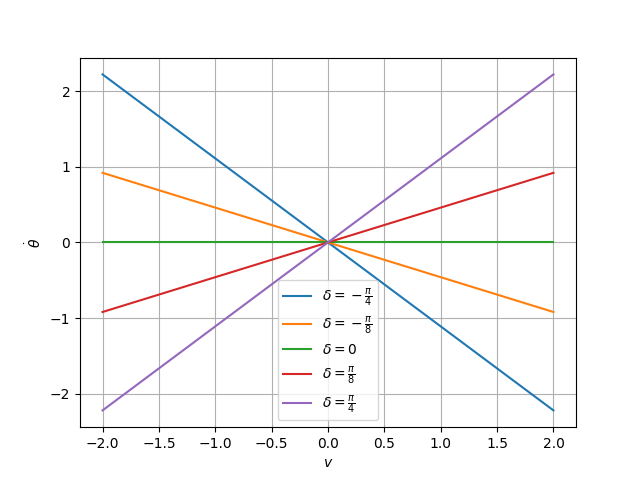

In [17]:
# Assuming theta_dot vs v plot for different values of delta

v = np.linspace(-2,2,100)
l = 0.9

delta_0 = -np.pi/4
delta_1 = -np.pi/8
delta_2 = 0
delta_3 = np.pi/8
delta_4 = np.pi/4

theta_dot_0 = v*np.tan(delta_0)/l
theta_dot_1 = v*np.tan(delta_1)/l
theta_dot_2 = v*np.tan(delta_2)/l
theta_dot_3 = v*np.tan(delta_3)/l
theta_dot_4 = v*np.tan(delta_4)/l
plt.figure()
plt.plot(v, theta_dot_0, label="$\\delta=-\\frac{\\pi}{4}$")
plt.plot(v, theta_dot_1, label="$\\delta=-\\frac{\\pi}{8}$")
plt.plot(v, theta_dot_2, label="$\\delta=0$")
plt.plot(v, theta_dot_3, label="$\\delta=\\frac{\\pi}{8}$")
plt.plot(v, theta_dot_4, label="$\\delta=\\frac{\\pi}{4}$")
plt.xlabel("$v$")
plt.ylabel("$\\dot\\theta$")
plt.legend()
plt.grid()
plt.show()


We know the rate of change of $\theta$ is proportional to $\delta$. Can you work out the sequence of $\delta$ to change $\theta$ as in the cubic polynomial shown above?

In [18]:
theta_dot = np.diff(poly_turn(np.pi/2,0))
v = 1
l = 0.9
delta = np.arctan(l*theta_dot/v)

print(delta)

[-0.04844344 -0.12920623 -0.18593495 -0.21942362 -0.23048008 -0.21942362
 -0.18593495 -0.12920623 -0.04844344]
